<a href="https://www.kaggle.com/code/wuttipats/titanic-classifier-neural-network-with-grid-cv?scriptVersionId=125895773" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Dataset Description
### Overview
The data has been split into two groups:
* training set (train.csv)
* test set (test.csv)

**The training set** should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use *feature engineering* to create new features.

**The test set** should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include **gender_submission.csv**, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Data Dictionary

| Variable |                 Definition                 |                       Key                      |
|:---------|:-------------------------------------------|:-----------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### Variable Notes
**pclass**: A proxy for socio-economic status (SES) <br>
1st = Upper <br>
2nd = Middle <br>
3rd = Lower <br>

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

source:
https://www.kaggle.com/competitions/titanic
<br><br><br><br>

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv').copy()
test = pd.read_csv('/kaggle/input/titanic/test.csv').copy()

### Data Cleaning and Proprocessing

In [3]:
numerical_features = ['age', 'fare']
categorical_features = ['pclass', 'sex', 'sibsp', 'parch', 'embarked']
removeable_features = ['passengerid', 'name', 'ticket', 'cabin']

In [4]:
# See Nan values
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# Rename columns name into lowercase
train.columns = [x.lower() for x in train.columns]

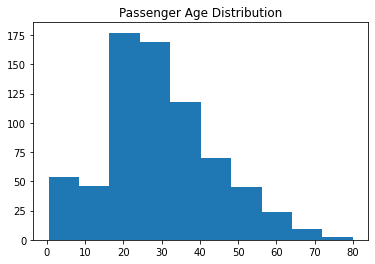

Age mean: 29.69911764705882
Age median: 28.0
Age mode: 0    24.0
dtype: float64


In [6]:
# Looking inside 'age' distribution
plt.hist(train.age)
plt.title('Passenger Age Distribution')
plt.show()


print('Age mean: {}'.format(train.age.mean()))
print('Age median: {}'.format(train.age.median()))
print('Age mode: {}'.format(train.age.mode()))



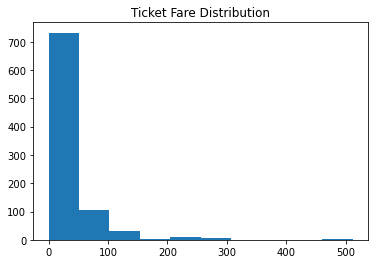

fare mean: 32.204207968574636
fare median: 14.4542
fare mode: 0    8.05
dtype: float64


In [7]:
# Looking inside 'fare' distribution
plt.hist(train.fare)
plt.title('Ticket Fare Distribution')
plt.show()

print('fare mean: {}'.format(train.fare.mean()))
print('fare median: {}'.format(train.fare.median()))
print('fare mode: {}'.format(train.fare.mode()))


In [8]:
# Rename columns name into lowercase
def rename_cols(df):
    df.columns = [x.lower() for x in df.columns]
    return df

In [9]:
# Remove unwanted columns
def remove_unwanted_cols(df):
    df = df.drop(labels=removeable_features, axis=1)
    return df

In [10]:
# Filter out outliers
def filter_outlier(df):
    # Select the columns to filter out outliers
    cols_to_filter = numerical_features

    # Calculate the quartiles and interquartile range
    Q1 = df[cols_to_filter].quantile(0.25)
    Q3 = df[cols_to_filter].quantile(0.75)
    IQR = Q3 - Q1

    # Set the lower and upper thresholds
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR

    # Filter the df
    df = df[~((df[cols_to_filter] < lower_threshold) | (df[cols_to_filter] > upper_threshold)).any(axis=1)]
    
    return df

In [11]:
def imputer(df):
    # Missing values imputer
    from sklearn.impute import SimpleImputer

    # Create an imputer object with median strategy
    imputer = SimpleImputer(strategy='median')

    # Fit the imputer object on the age column
    imputer.fit(df[numerical_features])

    # Transform the age column
    df[numerical_features] = imputer.transform(df[numerical_features])

    return df

In [12]:
# Apply One-hot encode
def one_hot(df):
    # Transform categorical features into dummies variables
    df = pd.get_dummies(data=df, columns=categorical_features, drop_first=True)
    return df

In [13]:
def scaler(df):
    
    from sklearn.preprocessing import StandardScaler

    # Create standardscaler instace
    scaler = StandardScaler()

    # Fit the instace on the selected columns
    scaler.fit(df[numerical_features])

    # Transform the selected columns
    df[numerical_features] = scaler.transform(df[numerical_features])
    
    return df

### Machine Learning

In [14]:
# Performing hyperparameter tuning
def grid_search():
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.linear_model import SGDClassifier
    from sklearn.model_selection import GridSearchCV, cross_val_score
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    from catboost import CatBoostClassifier

    # Load the data
    X_train, y_train = train.drop('survived', axis=1), train.survived
    X_test = test
    
    # Define the models to be used
    models = {
        'LogisticRegression': LogisticRegression(),
        'SVC': SVC(),
        'RandomForestClassifier': RandomForestClassifier(),
        'KNeighborsClassifier': KNeighborsClassifier(),
        'GaussianNB': GaussianNB(),
        'SGDClassifier': SGDClassifier(),
        'GradientBoostingClassifier': GradientBoostingClassifier(),
        'XGBClassifier': XGBClassifier(),
        'LGBMClassifier': LGBMClassifier(),
        'AdaBoostClassifier': AdaBoostClassifier()

    }

    # Define the hyperparameters to be tuned
    hyperparameters = {
        'LogisticRegression': {'C': [0.1, 1, 10], 'penalty': ['l2']},
        'SVC': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
        'RandomForestClassifier': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
        'KNeighborsClassifier': {'n_neighbors': [20, 40, 80], 'weights': ['uniform', 'distance']},
        'GaussianNB': {},
        'SGDClassifier': {'loss': ['hinge', 'log_loss'], 'penalty': ['l1', 'l2', 'elasticnet']},
        'GradientBoostingClassifier': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
        'XGBClassifier': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
        'LGBMClassifier': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]},
        'AdaBoostClassifier': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}

    }

    # Train and tune each model using GridSearchCV
    for model_name, model in models.items():
        print(model_name + 'Running.......')
        gs = GridSearchCV(model, hyperparameters[model_name], cv=5, verbose=0)
        gs.fit(X_train, y_train)
        models[model_name] = gs
        
        # Generate predict results over the models
    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)

        # Create .csv predict result
        result_dict = {'PassengerId':pd.read_csv('/kaggle/input/titanic/test.csv').copy().PassengerId,
                       'Survived': y_pred}
        df = pd.DataFrame(result_dict)
        df.to_csv('/kaggle/working/{}.csv'.format(name),index=False)
        print("Create .csv Model: {} --> Done".format(name))

        
    # Evaluate the models on the test set
    for model_name, gs in models.items():
        # Best score for each model
        print(f'{model_name} best score: {gs.best_score_:.2f}')
    print()
    
    for model_name, gs in models.items():
        # Best parameters for each model
        print(f'{model_name} best params: {gs.best_params_}')
    print()
        
    for model_name, gs in models.items():
        cv_score = cross_val_score(gs, X_train, y_train, cv=5)
        print(f"{model_name} Regression Accuracy: {cv_score.mean():.2f} (+/- {cv_score.std():.2f})")

    for model_name, gs in models.items():
        # Best score for each model
        models[model_name] = gs.best_score_   
        
    # Get the list of models and their corresponding best scores
    model_names = list(models.keys())
    best_scores = list(list(models.values()))

    # Create a bar chart
    plt.bar(model_names, best_scores)
    plt.xlabel("Model")
    plt.ylabel("Mean Test Score")
    plt.title("Model Tuning Results")
    plt.xticks(rotation=90)
    plt.ylim(0.7, 0.85)
    plt.show()

LogisticRegressionRunning.......
SVCRunning.......
RandomForestClassifierRunning.......
KNeighborsClassifierRunning.......
GaussianNBRunning.......
SGDClassifierRunning.......
GradientBoostingClassifierRunning.......
XGBClassifierRunning.......
LGBMClassifierRunning.......
AdaBoostClassifierRunning.......
Create .csv Model: LogisticRegression --> Done
Create .csv Model: SVC --> Done
Create .csv Model: RandomForestClassifier --> Done
Create .csv Model: KNeighborsClassifier --> Done
Create .csv Model: GaussianNB --> Done
Create .csv Model: SGDClassifier --> Done
Create .csv Model: GradientBoostingClassifier --> Done
Create .csv Model: XGBClassifier --> Done
Create .csv Model: LGBMClassifier --> Done
Create .csv Model: AdaBoostClassifier --> Done
LogisticRegression best score: 0.80
SVC best score: 0.81
RandomForestClassifier best score: 0.82
KNeighborsClassifier best score: 0.79
GaussianNB best score: 0.37
SGDClassifier best score: 0.78
GradientBoostingClassifier best score: 0.81
XGBClass

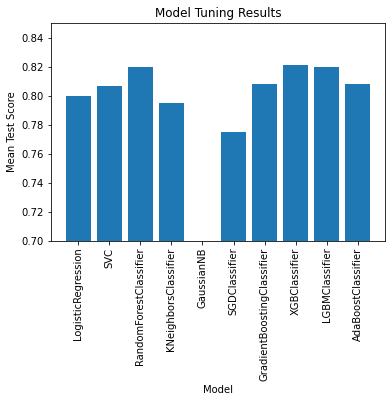

Time elapsed:  248.39424443244934


In [15]:
import time
start_time = time.time()

# Load data
train = pd.read_csv('/kaggle/input/titanic/train.csv').copy()
test = pd.read_csv('/kaggle/input/titanic/test.csv').copy()

# Data cleaning and preprocessing
train = rename_cols(train)
train = remove_unwanted_cols(train)
train = filter_outlier(train)
train = imputer(train)
train = one_hot(train)
train = scaler(train)

test = rename_cols(test)
test = remove_unwanted_cols(test)
test = imputer(test)
test = one_hot(test)
test = scaler(test)
test = test.drop(['sibsp_8', 'parch_9'], axis=1)

# Performing hyperparameter tuning
grid_search()

end_time = time.time()
time_elapsed = end_time - start_time
print("Time elapsed: ", time_elapsed)

In [16]:
def run_models(gen=False):
    # Model training, predict, and evaluate
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier

    # Load the data
    X_train, y_train = train.drop('survived', axis=1), train.survived
    X_test = test
    
    # Initialize the models
    models = {'Logistic Regression': LogisticRegression(C=10, fit_intercept=True, max_iter=100, penalty='l2'),
              'Support Vector Machine': SVC(C=1, kernel='rbf'),
              'Random Forest': RandomForestClassifier(criterion='entropy', n_estimators=50, max_depth=10, random_state=21)}

    # Iterate over the models
    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
       
        if gen == False :
            pass
        else:
            # Create .csv predict result
            result_dict = {'PassengerId':pd.read_csv('/kaggle/input/titanic/test.csv').copy().PassengerId,
                           'Survived': y_pred}
            df = pd.DataFrame(result_dict)
            df.to_csv('/kaggle/working/{}.csv'.format(name),index=False)
            print("Create .csv Model: {} --> Done".format(name))
            print()
        

In [17]:
# Load data
train = pd.read_csv('/kaggle/input/titanic/train.csv').copy()
test = pd.read_csv('/kaggle/input/titanic/test.csv').copy()

# Data cleaning and preprocessing
train = rename_cols(train)
train = remove_unwanted_cols(train)
train = filter_outlier(train)
train = imputer(train)
train = one_hot(train)
train = scaler(train)
test = rename_cols(test)
test = remove_unwanted_cols(test)
test = imputer(test)
test = one_hot(test)
test = scaler(test)
test = test.drop(['sibsp_8', 'parch_9'], axis=1)

# Train and elevauate the model
run_models(gen=True) # gen=True will return predicted result as .csv file

Create .csv Model: Logistic Regression --> Done

Create .csv Model: Support Vector Machine --> Done

Create .csv Model: Random Forest --> Done



# Neural Network

In [18]:
train.head()

,survived,age,fare,pclass_2,pclass_3,sex_male,sibsp_1,sibsp_2,sibsp_3,sibsp_4,sibsp_5,parch_1,parch_2,parch_3,parch_4,parch_5,parch_6,embarked_Q,embarked_S
0,0,-0.519955,-0.778143,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1
2,1,-0.185188,-0.728035,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0.568037,2.625508,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0.568037,-0.718755,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,-0.017805,-0.688445,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [19]:
train.shape

(765, 19)

In [20]:
test

,age,fare,pclass_2,pclass_3,sex_male,sibsp_1,sibsp_2,sibsp_3,sibsp_4,sibsp_5,parch_1,parch_2,parch_3,parch_4,parch_5,parch_6,embarked_Q,embarked_S
0,0.386231,-0.497413,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1.371370,-0.512278,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,2.553537,-0.464100,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,-0.204852,-0.482475,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,-0.598908,-0.417492,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,-0.204852,-0.493455,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
414,0.740881,1.314435,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
415,0.701476,-0.507796,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
416,-0.204852,-0.493455,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [21]:
print(train.shape)
print(test.shape)

(765, 19)
(418, 18)


In [22]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)


X_train = train.drop('survived', axis=1)
y_train = train.survived



# Define the model
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(64, activation='relu', input_shape=(18,)),
#     tf.keras.layers.Dense(64, activation='relu'),

#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1216      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6

Epoch 1/50
20/20 [==============================] - 3s 13ms/step - loss: 0.6614 - accuracy: 0.6062 - val_loss: 0.5779 - val_accuracy: 0.6863
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.5822 - accuracy: 0.6683 - val_loss: 0.5086 - val_accuracy: 0.7386
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.5522 - accuracy: 0.7157 - val_loss: 0.4571 - val_accuracy: 0.7908
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.5198 - accuracy: 0.7582 - val_loss: 0.4309 - val_accuracy: 0.8105
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.5040 - accuracy: 0.7712 - val_loss: 0.4190 - val_accuracy: 0.8039
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.4780 - accuracy: 0.7778 - val_loss: 0.4176 - val_accuracy: 0.8235
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.4793 - accuracy: 0.7761 - val_loss: 0.4048 - val_accuracy: 0.8170
Epoch 8/50
20/20 [=

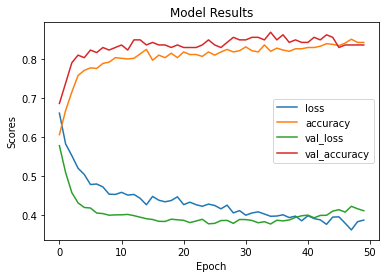

0.8692810535430908


In [23]:
# Train the model
early_stopping = EarlyStopping(patience=5)
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,)
#                     callbacks=early_stopping)

import matplotlib.pyplot as plt

results =  history.history
# Plot the accuracy history
# plot each line in the dictionary
for key in results:
    plt.plot(results[key], label=key)
    
    
# Plot a model results    
plt.title('Model Results')
plt.ylabel('Scores')
plt.xlabel('Epoch')
plt.legend(list(results.keys()))
plt.show()

print(max(history.history['val_accuracy']))

In [24]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore') # Hide all warnings

tf.random.set_seed(42)

# Load input data
X_train = train.drop('survived', axis=1)
y_train = train.survived

batch_size = [16,32,64]
epochs = [20,25,30]
optimizer = ['adam', 'rmsprop']
cv = 5 # None mean default (K-fold=5)

def create_model(optimizer):
    model = Sequential()
    model.add(Dense(64, activation='relu',  input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


model = KerasClassifier(build_fn=create_model)

param_grid = {'batch_size': batch_size,
              'epochs': epochs,
              'optimizer': optimizer,}


grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv) 
grid_result = grid.fit(X_train,y_train, verbose=0)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

3/3 [==============================] - 0s 3ms/step - loss: 0.4139 - accuracy: 0.8170
Best: 0.809150 using {'batch_size': 32, 'epochs': 25, 'optimizer': 'rmsprop'}
0.807843 (0.038909) with: {'batch_size': 16, 'epochs': 20, 'optimizer': 'adam'}
0.802614 (0.035894) with: {'batch_size': 16, 'epochs': 20, 'optimizer': 'rmsprop'}
0.789542 (0.042034) with: {'batch_size': 16, 'epochs': 25, 'optimizer': 'adam'}
0.801307 (0.035463) with: {'batch_size': 16, 'epochs': 25, 'optimizer': 'rmsprop'}
0.794771 (0.031099) with: {'batch_size': 16, 'epochs': 30, 'optimizer': 'adam'}
0.798693 (0.027853) with: {'batch_size': 16, 'epochs': 30, 'optimizer': 'rmsprop'}
0.796078 (0.028158) with: {'batch_size': 32, 'epochs': 20, 'optimizer': 'adam'}
0.798693 (0.041213) with: {'batch_size': 32, 'epochs': 20, 'optimizer': 'rmsprop'}
0.800000 (0.037796) with: {'batch_size': 32, 'epochs': 25, 'optimizer': 'adam'}
0.809150 (0.027232) with: {'batch_size': 32, 'epochs': 25, 'optimizer': 'rmsprop'}
0.806536 (0.038021) wi

In [25]:
# Load test data

X_test = test
# name = 'neural_network_predict'
name = 'submission'
# Evaluate the model
y_pred = grid.predict(X_test)

# FLatten data
data = y_pred
y_pred = [val for sublist in data for val in sublist]

# Create .csv predict result
result_dict = {'PassengerId':pd.read_csv('/kaggle/input/titanic/test.csv').copy().PassengerId,
               'Survived': y_pred}

df = pd.DataFrame(result_dict)
df.to_csv('/kaggle/working/{}.csv'.format(name),index=False)
print("Create .csv Model: {} --> Done".format(name))

Create .csv Model: submission --> Done
